# **Decode COVID19 with Genome Analysis**

**Problem Statement :**
You are one of the researchers responding to the White House Office of Science and Technology Policy center’s call to conduct advanced research on Covid-19. You are working with CDC,  which has led a coordinated effort to set up a machine readable dataset.

**About Dataset :**
Dataset represents the most extensive machine-readable coronavirus literature collection available for data and text mining to date, with over 29,000 articles, more than 13,000 of which have full text.

Using the **CORD-NER dataset** and Knowledge Graph, determine and map out the details of the SARS-CoV-2 genome to assist understanding of the emergence, evolution and diagnosis of this deadly virus.



In [1]:
#clearing cache to avoid ran out of memory error
import gc 
def report_gpu(): 
    print(torch.cuda.list_gpu_processes()) 
    gc.collect() 
    torch.cuda.empty_cache()

In [2]:
#importing required libraries
import pandas as pd 
import numpy as np
from tqdm import tqdm 
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import warnings
import pprint
import tensorflow as tf

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#clearing cache to avoid ran out of memory error
import gc 
def report_gpu(): 
    print(torch.cuda.list_gpu_processes()) 
    gc.collect() 
    torch.cuda.empty_cache()

# 1. Importing Dataset & preprocessing

In [4]:
#importing 10000 rows from CORD-NER-full json file
json_data = pd.read_json('/kaggle/input/cordner2020/CORD-NER-full.json',nrows=10000, lines=True)


In [5]:
#clearing cache to avoid ran out of memory error
import gc 
def report_gpu(): 
    print(torch.cuda.list_gpu_processes()) 
    gc.collect() 
    torch.cuda.empty_cache()

In [6]:
#conversion to csv
json_data.to_csv('CORD_NER-Full.csv')

In [7]:
#importing csv data
data = pd.read_csv('/kaggle/working/CORD_NER-Full.csv')
data.head(10)

,Unnamed: 0,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities
0,0,0,CZI,10.1007/s00134-020-05985-9,NaN,32125455.0,2020,"Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...",Intensive Care Med,Angiotensin-converting enzyme 2 (ACE2) as a SA...,NaN,SARS-CoV-2 has been sequenced [3] . A phylogen...,"[{'text': 'Angiotensin-converting enzyme 2', '..."
1,1,1,CZI,10.1038/s41421-020-0147-1,NaN,NaN,2020,"Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...",Cell Discovery,Comparative genetic analysis of the novel coro...,NaN,Comparative genetic analysis of the novel coro...,"[{'text': 'genetic analysis', 'start': 12, 'en..."
2,2,2,CZI,10.3390/jcm9020538,NaN,NaN,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,The geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ..."
3,3,3,CZI,10.3390/jcm9020575,NaN,32093211.0,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"In December 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':..."
4,4,4,CZI,10.1007/s00134-020-05976-w,NaN,32125453.0,2020,"Zhang, Wei",Intensive Care Med,Imaging changes in severe COVID-19 pneumonia,NaN,NaN,"[{'text': 'COVID-19', 'start': 26, 'end': 34, ..."
5,5,5,CZI,10.1016/j.idm.2020.02.001,NaN,NaN,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,The basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7..."
6,6,6,CZI,10.1016/j.idm.2020.02.002,NaN,NaN,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,The initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,..."
7,7,7,CZI,10.1016/s2214-109x(20)30065-6,NaN,32105614.0,2020,"Zeng, Yingchun; Zhen, Yan",The Lancet. Global health,RETRACTED: Chinese medical staff request inter...,NaN,NaN,"[{'text': 'Chinese', 'start': 11, 'end': 18, '..."
8,8,8,CZI,10.1093/jtm/taaa030,NaN,NaN,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,COVID-19 outbreak on the Diamond Princess crui...,Cruise ships carry a large number of people in...,Conclusions: The cruise ship conditions clearl...,"[{'text': 'COVID-19', 'start': 0, 'end': 8, 't..."
9,9,9,CZI,10.1128/mBio.02764-19,NaN,NaN,2020,"Qing, Enya; Hantak, Michael; Perlman, Stanley;...",mBio,Distinct Roles for Sialoside and Protein Recep...,Coronaviruses (CoVs) are common human and anim...,could be attributed to S proteins. Intriguingl...,"[{'text': 'Sialoside', 'start': 19, 'end': 28,..."


In [8]:
#looking for articles published in 2020
data = data[data.publish_time=='2020']
print(f'There are {len(data)} articles published in 2020')

There are 1148 articles published in 2020


In [9]:
#dropping articles with missing abstract
len1 = len(data)
data.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
print(f'Dropped {len1-len(data)} articles with missing abstract')

Dropped 370 articles with missing abstract


In [10]:
#dropping articles with duplicate abstract
len1 = len(data)
data.drop_duplicates(subset=['abstract'],keep='first',inplace=True)
print(f'Dropped {len1-len(data)} articles with duplicate abstract')

Dropped 6 articles with duplicate abstract


Warning: Although the articles with duplicated abstracts are dropped, there still exist some articles with meaningless abstracts. The cleaning strategy here only weakens the effects of those meaningless abstracts.

In [11]:
data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())
stopwords = set(stopwords.words('english'))
data['abstract_tokens'] = data['abstract'].apply(lambda x: word_tokenize(x))

## Remove non-English words
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w.isalpha()])

## Remove Stopwords
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords])

## Remove words with single characters
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if len(w)>1])
#data['abstract_cleaned'] = data['abstract_tokens'].apply(lambda x: ' '.join(x))
data.head()

,Unnamed: 0,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities,abstract_tokens
2,2,2,CZI,10.3390/jcm9020538,NaN,NaN,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ...","[geographic, spread, novel, coronavirus, infec..."
3,3,3,CZI,10.3390/jcm9020575,NaN,32093211.0,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':...","[december, cases, unidentified, pneumonia, his..."
5,5,5,CZI,10.1016/j.idm.2020.02.001,NaN,NaN,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7...","[basic, reproduction, number, infectious, agen..."
6,6,6,CZI,10.1016/j.idm.2020.02.002,NaN,NaN,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,...","[initial, cluster, severe, pneumonia, cases, t..."
8,8,8,CZI,10.1093/jtm/taaa030,NaN,NaN,2020,"Rocklöv, J.; Sjödin, H.; Wilder-Smith, A.",Journal of Travel Medicine,COVID-19 outbreak on the Diamond Princess crui...,cruise ships carry a large number of people in...,Conclusions: The cruise ship conditions clearl...,"[{'text': 'COVID-19', 'start': 0, 'end': 8, 't...","[cruise, ships, carry, large, number, people, ..."


In [12]:
data.reset_index(drop=True,inplace=True)

Here I create inverted index. Inverted index is a fundamental technology used commonly in search engine . Inverted index assigns each word with a list of document id and it helps retrieve the articles with keyword matching fastly. For example {'patient':[1,3,6]} means that the word patient occurs in the second,fourth and sixth document in the corpus.



In [13]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_tokens'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 8711 unique words in inverted index


# 2.Article Matching and Deep Cleaning

In [14]:
keywords_cov = ["sars-cov-2","sars","cov-2","2019-ncov","ncov","cov","covid19","covid","corona",
             "coronavirus"]
cov_idx = []
for word in keywords_cov:
    try:
        cov_idx += inverted_idx[word]
    except:
        pass
cov_idx = list(set(cov_idx))
print(f'Found {len(cov_idx)} articles related to covid19')

Found 606 articles related to covid19


In [15]:
cov_article = data.iloc[cov_idx,:]
cov_article.head()

,Unnamed: 0,id,source,doi,pmcid,pubmed_id,publish_time,authors,journal,title,abstract,body,entities,abstract_tokens
0,2,2,CZI,10.3390/jcm9020538,NaN,NaN,2020,"Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...",Journal of Clinical Medicine,Incubation Period and Other Epidemiological Ch...,the geographic spread of 2019 novel coronaviru...,"As of 31 January 2020, mainland China reported...","[{'text': '2019', 'start': 63, 'end': 67, 'typ...","[geographic, spread, novel, coronavirus, infec..."
1,3,3,CZI,10.3390/jcm9020575,NaN,32093211.0,2020,"Deng, Sheng-Qun; Peng, Hong-Juan",J Clin Med,Characteristics of and Public Health Responses...,"in december 2019, cases of unidentified pneumo...","In December 2019, a cluster of pneumonia of un...","[{'text': 'Public Health', 'start': 23, 'end':...","[december, cases, unidentified, pneumonia, his..."
2,5,5,CZI,10.1016/j.idm.2020.02.001,NaN,NaN,2020,"Tang, Biao; Bragazzi, Nicola Luigi; Li, Qian; ...",Infectious Disease Modelling,An updated estimation of the risk of transmiss...,the basic reproduction number of an infectious...,Coronaviruses are a group of enveloped viruses...,"[{'text': 'coronavirus', 'start': 63, 'end': 7...","[basic, reproduction, number, infectious, agen..."
3,6,6,CZI,10.1016/j.idm.2020.02.002,NaN,NaN,2020,"Roosa, K.; Lee, Y.; Luo, R.; Kirpich, A.; Roth...",Infectious Disease Modelling,Real-time forecasts of the 2019-nCoV epidemic ...,the initial cluster of severe pneumonia cases ...,The ongoing epidemic of the novel coronavirus ...,"[{'text': '2019-nCoV', 'start': 27, 'end': 36,...","[initial, cluster, severe, pneumonia, cases, t..."
5,9,9,CZI,10.1128/mBio.02764-19,NaN,NaN,2020,"Qing, Enya; Hantak, Michael; Perlman, Stanley;...",mBio,Distinct Roles for Sialoside and Protein Recep...,coronaviruses (covs) are common human and anim...,could be attributed to S proteins. Intriguingl...,"[{'text': 'Sialoside', 'start': 19, 'end': 28,...","[coronaviruses, covs, common, human, animal, p..."


For topic modeling and visualization, lemmatization is needed. POS tagging technique is also used to filter meaningful words.

In [16]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        ##'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out   

First, let's see how the word cloud of this corpus looks like.

Text(0.5, 1.0, 'Word Cloud: Articles Related to SAR-Cov-2')

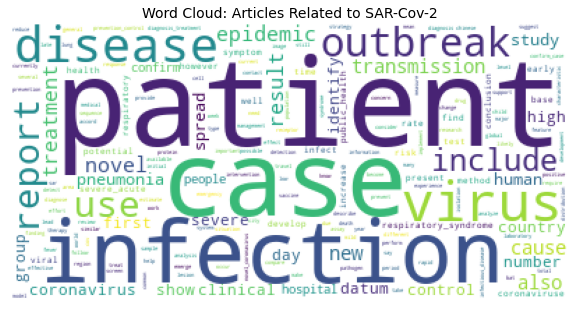

In [17]:
cov_article['Lemma_Tokens'] = lemmatization(list(cov_article['abstract_tokens']))
## convert tokens that frequently occur together as bigram and trigram
bigram = Phrases(list(cov_article['Lemma_Tokens']), min_count=3)
cov_article['Phrase_Lemma_Tokens'] = cov_article['Lemma_Tokens'].apply(lambda x: bigram[x])


cov_abstract_tokens = []
for tokens in list(cov_article['Phrase_Lemma_Tokens']):
    cov_abstract_tokens += tokens
cov_wordcnt_dict = collections.Counter(cov_abstract_tokens)

wcloud = wordcloud.WordCloud(background_color='white')
wcloud.generate_from_frequencies(cov_wordcnt_dict)
fig,ax = plt.subplots(figsize=(10,8))
ax.imshow(wcloud)
for pos in ['left','right','top','bottom']:
    ax.spines[pos].set_color(None)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Word Cloud: Articles Related to SAR-Cov-2' ,fontsize=14)

Words or phrases like  'patient', 'infection', 'disease', 'outbreak', 'virus', 'case, 'epidemic' occur frequently in this corpus.

# 3.Topic Extraction : LDA

100%|██████████| 8/8 [00:43<00:00,  5.47s/it]


Topic number selection took 43.76024913787842 seconds


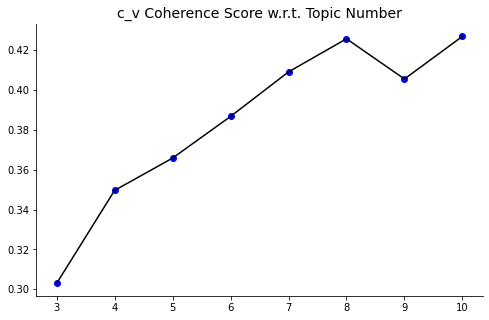

In [18]:
#https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
id2token_cov_article = corpora.Dictionary(list(cov_article['Phrase_Lemma_Tokens']))
##eliminate rare and frequent tokens

corpus_cov_article = [id2token_cov_article.doc2bow(tokens) 
                        for tokens in list(cov_article['Phrase_Lemma_Tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpus_cov_article,
                            id2word=id2token_cov_article,
                            num_topics=nb_topics, 
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=50,
                            decay=0.5,
                            per_word_topics=True,)
    #cm = CoherenceModel(model=lda_model, corpus=corpus_smoke_article, coherence='u_mass')
    cm = CoherenceModel(model=lda_model, 
                        texts=list(cov_article['Phrase_Lemma_Tokens']),
                        dictionary=id2token_cov_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)
    
print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='black')
ax.scatter(range(3,11),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14)
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

The higher the c_v coherence score is, the more suitable the topic number should be. Hence, I choose 8 as the topic number for analysis.

In [19]:
lda_model = LdaMulticore(corpus=corpus_cov_article,
                        id2word=id2token_cov_article,
                        num_topics=8, 
                        random_state=98,
                        chunksize=100,
                        passes=10,
                        iterations=50,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_cov_article))

Perplexity:  -7.8894986301297605


# Word per Topic

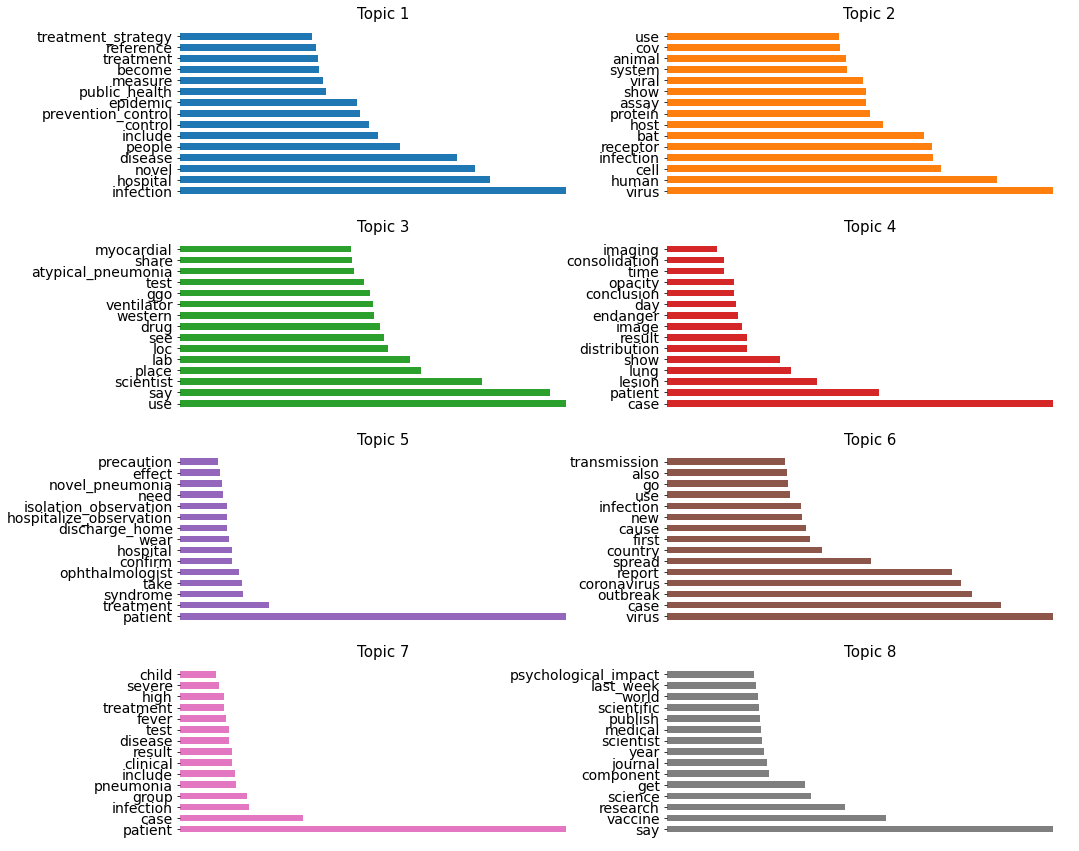

In [20]:
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,15))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(4,2,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=sns.color_palette()[i])
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

1. First topic is talking about the hospital practices to ensure the public health by adopting public treatment strategies and infection prevention control measures. We can see words like 'infection', 'hospital', 'disease', 'prevention_control','public health','treatment strategies'.

2. Second topic is probably talking about evolution of virus inside human host. We can see words like  'virus', 'human', 'cell','host','protein','infection'.

3. Third topic talks about Scientists testion western drugs in lab for atypical pneumonia and myocardial. We can see words like 'Scientist', 'lab', 'test', 'ventilator', 'drug','western','atypical pneumonia','myocardial'.

4. Fourth topic probably talks about most of the patient cases orignated from distribution of lesions in lungs that were infected. We can see words like 'patient', 'case', 'lesion', 'infection', 'lung', 'distribuion'.

5. Fifth topic talks about observation on hospitalised COVID19 confirmed patients for syndrome, treatment, effect and precaution in isolation. We can see words like 'patient', 'treatment', 'syndrome', 'confirm', 'hospitalize_observation','effect','precaution'.

6. Sixth topic talks about rise in cases of COVID19 in the country. We can see words like 'country', 'case', 'transmission', 'outbreak', 'report', 'virus'.

7. Seventh topic probably talks about symptoms of COVID19 in a patient. We can see words like 'patient','case','fever','high'.

8. Eighth topic probably talks about psychological impact and research on vaccine by scientists in medical world and also about COVID19 cases in wild animals. We can see words like 'vaccine','scientist','research',medical','journal','wild_animal'.

# 4. LDA Visualization

In [21]:
from pyLDAvis import gensim

In [22]:

%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus_cov_article, id2token_cov_article)

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


CPU times: user 419 ms, sys: 252 ms, total: 671 ms
Wall time: 2.74 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.021936  0.201413       1        1  32.176789
0     -0.103620  0.169804       2        1  20.767984
6     -0.075394 -0.056285       3        1  17.938757
3      0.020704 -0.146487       4        1   8.467174
1      0.134938  0.030286       5        1   7.557650
4     -0.305462 -0.106744       6        1   5.670049
7      0.183607 -0.031227       7        1   4.948577
2      0.167163 -0.060760       8        1   2.473019, topic_info=           Term        Freq       Total Category  logprob  loglift
239     patient  855.000000  855.000000  Default  30.0000  30.0000
61         case  629.000000  629.000000  Default  29.0000  29.0000
56        virus  392.000000  392.000000  Default  28.0000  28.0000
52    treatment  245.000000  245.000000  Default  27.0000  27.0000
1166   hospital  206.000000  206.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1045      share    5.018075   36.455414   Topic8  -5.4756   1.7167
412        test    5.378013   91.553308   Topic8  -5.4063   0.8651
530     protein    3.811553   59.471071   Topic8  -5.7506   0.9523
660   condition    3.572408   28.394909   Topic8  -5.8154   1.6268
348     control    3.704215  111.165855   Topic8  -5.7792   0.2982

[486 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1550      4  0.940952       accompany
2334      3  0.965156            acid
756       3  0.943369           acute
4247      6  0.921328  advanced_stage
1222      1  0.977878          almost
...     ...       ...             ...
1054      1  0.180735            year
1054      2  0.040163            year
1054      3  0.481959            year
1054      4  0.100408            year
1054      7  0.200816            year

[880 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 7, 4, 2, 5, 8, 3])

As we can see from the interactive figure above, topic 1 and 2  are very close as well as 7 and 8 (5 is also similar to 7). The other topics are separated appropriately.


# Topic per document

In [23]:
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_cov_article)):
    document_topic = lda_model.get_document_topics(corpus_cov_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1

topic_frequency = dict(sorted(topic_frequency.items()))

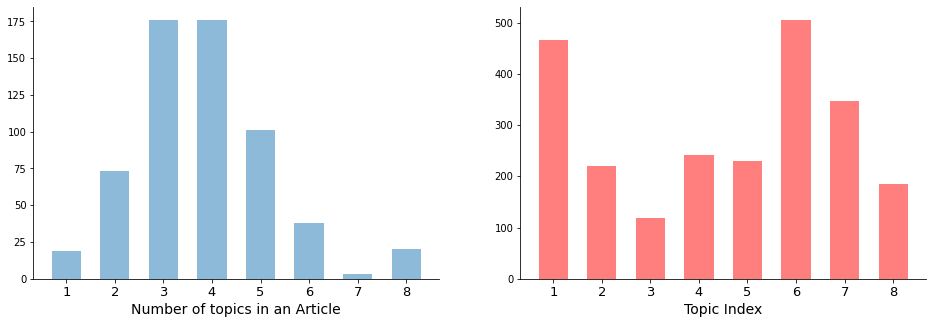

In [24]:
#num_topic_document_counter = collections.Counter(num_topic_document)
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6','7','8'],fontsize=13)

1.The left figure shows that there are very few articles who covered all the topics. 3rd and 4th topic are mostly present in many articles..

2.The right figure shows that occurence frequencies of topics are not very close as we can see many articles covered 1st and 6th topic.


In [25]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_cov_article),8))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

,0,1,2,3,4,5,6,7
0,0.130284,0.000000,0.000000,0.485026,0.070179,0.265749,0.043615,0.000000
1,0.413572,0.000000,0.317701,0.000000,0.000000,0.158708,0.103837,0.000000
2,0.465558,0.000000,0.000000,0.092126,0.000000,0.322996,0.000000,0.115071
3,0.000000,0.000000,0.000000,0.000000,0.037105,0.957715,0.000000,0.000000
4,0.000000,0.994202,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [26]:
#T-SNE clustering of LDA topics
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon',
                  6: 'purple', 7:'darkred'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Infection prevention measures by hospital', 1: 'Evolution of virus', 
                  2: 'Drugs for atypical pneumonia and myocardial', 
                  3: 'lesions in lungs', 4: 'Observation on COVID19 patient', 5:'Rise of COVID19 in the Country',
                  6: 'Symptoms of COVID19', 7: 'Research on vaccine'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(cov_article['title'])

output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

Loading BokehJS ...

**Why Choose T-SNE?**

T-SNE gives the impression that it has classified the data by bringing it to two-dimensions but in reality, it doesn’t reduce the dimensions. It is a visualizer, which tells how each class is distributed and is there any overlap between them'. An intuition of T-SNE from the article on Medium: PCA vs LDA vs T-SNE — Let’s Understand the difference between them.

